In [2]:
import numpy as np
df=np.load("/Users/rohitviswam/Downloads/CSI-02-0005/H_32T4R_30_1RB.npy")
data=df.reshape(2100,398,256)
data.shape
feature_len=data.shape[-1]

In [3]:
data.shape

(2100, 398, 256)

In [4]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [5]:
data_flattened = data.reshape(data.shape[0], -1)  # shape becomes (2100, 398*256)


In [6]:
data = data_flattened

In [7]:
# Parameters
n_samples = 2100
n_timesteps = 398 * 256
window_size = 10
test_size = 0.2  # 20% for testing

# Initialize lists to hold models and predictions/actuals for each UE
models = []
predictions = []
actuals = []

In [8]:
for ue in range(n_samples):
    # Extract data for this specific UE
    ue_data = data[ue, :]  # Shape: (n_timesteps,)
    
    # Create non-overlapping window pairs (input sequences and targets)
    X_ue = []
    y_ue = []
    
    for i in range(0, len(ue_data) - window_size, window_size):
        # Use the current window for input
        X_ue.append(ue_data[i:i + window_size])
        # Predict the next value immediately following the current window
        if i + window_size < len(ue_data):
            y_ue.append(ue_data[i + window_size])

    # Convert to NumPy arrays
    X_ue = np.array(X_ue)
    y_ue = np.array(y_ue)

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_ue, y_ue, test_size=test_size, random_state=42)

    # Initialize the XGBoost model
    model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, objective='reg:squarederror')
    
    # Train the model on the training set
    model.fit(X_train, y_train)
    
    # Make predictions on the testing set
    y_pred = model.predict(X_test)
    
    # Save the predictions and actuals for evaluation
    predictions.append(y_pred)
    actuals.append(y_test)
    
    # Save the model for this UE
    models.append(model)

In [9]:
import pandas as pd

# Initialize an empty list to store DataFrames for each UE
all_results = []

# Iterate through the predictions and actuals stored previously
for ue_index, (y_pred, y_test) in enumerate(zip(predictions, actuals)):
    # Create a DataFrame with columns for actual and predicted values
    results_df = pd.DataFrame({
        "Actual": y_test,
        "Predicted": y_pred
    })
    
    # Add a column to indicate the UE number
    results_df["UE"] = f"UE_{ue_index + 1}"
    
    # Append to the list of DataFrames
    all_results.append(results_df)

# Concatenate all DataFrames into one
final_results = pd.concat(all_results, ignore_index=True)

# Display the final combined table
print(final_results)


           Actual  Predicted       UE
0       -0.781295  -0.548046     UE_1
1        0.636567   0.831203     UE_1
2       -1.029850  -0.858506     UE_1
3       -0.472827  -0.278175     UE_1
4       -0.383845  -0.583184     UE_1
...           ...        ...      ...
4279795 -0.923270  -0.965407  UE_2100
4279796  1.018100   0.931536  UE_2100
4279797 -0.852918  -0.538602  UE_2100
4279798  0.755552   0.639915  UE_2100
4279799 -0.146493  -0.506189  UE_2100

[4279800 rows x 3 columns]


In [10]:
import matplotlib.pyplot as plt

# Function to visualize predictions for a specific UE
def visualize_predictions(ue_index):
    if ue_index < 0 or ue_index >= len(predictions):
        raise ValueError("Invalid UE index")
    
    # Retrieve the actual and predicted values for the given UE index
    y_pred = predictions[ue_index]
    y_test = actuals[ue_index]
    
    # Plot actual and predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(y_test[0:100], label="Actual", marker='o')
    plt.plot(y_pred[0:100], label="Predicted", marker='x')
    plt.title(f"Actual vs. Predicted Values for UE {ue_index + 1}")
    plt.xlabel("Index")
    plt.ylabel("Values")
    plt.legend()
    plt.grid(True)
    plt.show()


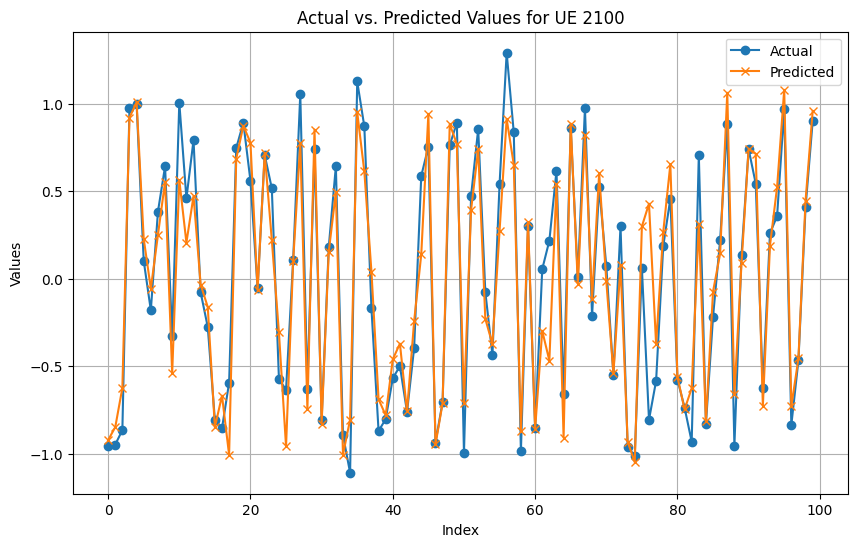

In [11]:
# Example usage to visualize the results for the first UE (index 0)
visualize_predictions(2099)

In [12]:
final_results.to_csv("ue_predictions_comparison2(10WS).csv", index=False)

In [13]:
# Assuming X_test and y_test are your test datasets
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE: ", rmse)

RMSE:  0.236334573566848


In [18]:
import numpy as np

# Assuming y contains your target variable values
min_value = np.min(y_ue)
max_value = np.max(y_ue)

print("Minimum Value:", min_value)
print("Maximum Value:", max_value)

Minimum Value: -1.55654
Maximum Value: 1.48339


In [19]:
accuracy = 100- (rmse /( max_value-min_value)) * 100

In [20]:
accuracy

92.22565738135917

In [17]:
# Optionally save to a CSV file for further analysis
# final_results.to_csv("ue_predictions_comparison-10.csv", index=False)